In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math 
import random

import time
import string

from random_username.generate import generate_username
from faker import Faker

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# row count in data
row_c = 5000

fake = Faker()

In [3]:
# functions for generating random date

def str_time_prop(start, end, format, prop):
    stime = time.mktime(time.strptime(start, format))
    etime = time.mktime(time.strptime(end, format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%m/%d/%Y', prop)

In [4]:
# fullname
fullname_col = [fake.name() for _ in range(row_c)]

# address
address_col = [fake.address() for _ in range(row_c)]

# gender 0 -> female, 1 -> male
gender_col = np.random.randint(0, 2, row_c)

# expertize 0 -> software engineer, 1 -> graphics designer, 2 -> other
expertize_col = np.random.randint(0, 3, row_c)

# username
username_col = generate_username(row_c)

# password
password_col = [''.join(random.choice(string.ascii_lowercase) for _ in range(np.random.randint(8, 15))) for __ in range(row_c)]

# status 0 -> unverified, 1 -> verified 
status_col = np.random.randint(0, 2, row_c)

# date
registrationTime_col = [random_date("9/1/2019", "10/30/2019", random.random()) for _ in range(row_c)]

In [5]:
data = pd.DataFrame()

# defining the columns of the dataset
data['fullname'] = fullname_col
data['address'] = address_col
data['gender'] = gender_col
data['expertize'] = expertize_col
data['username'] = username_col
data['password'] = password_col
data['status'] = status_col
data['registrationTime'] = registrationTime_col

data.reset_index(inplace=True)
data.rename(columns={"index": "userId"}, inplace=True)

dataset1 = data[['userId', 'fullname', 'address', 'gender', 'expertize']]
dataset2 = data[['userId', 'username', 'password', 'status', 'registrationTime']]

In [6]:
# save to disk
dataset1.to_csv('dataset1.csv', index=False)
dataset2.to_csv('dataset2.csv', index=False)

### Visualizing gender on verified users

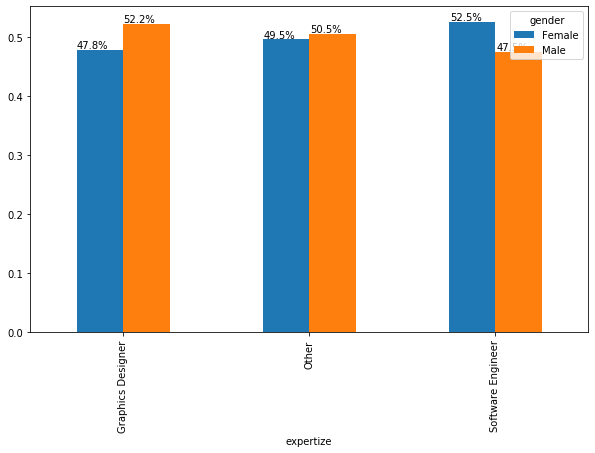

In [7]:
a = data[data['status'] == 1][['gender', 'expertize']]
a['expertize'] = a['expertize'].apply(lambda x : {0 : 'Software Engineer', 1 : 'Graphics Designer', 2 : 'Other'}[x])
a['gender'] = a['gender'].apply(lambda x : {0 : 'Female', 1 : 'Male'}[x])

prop_df = a['gender'].groupby(a['expertize']).value_counts(normalize=True).unstack()

ax = prop_df.plot(kind='bar', figsize=(10,6))

for p in ax.patches:
    ax.annotate(str(np.round(p.get_height() * 100, 1)) + '%', (p.get_x() * 1.005, p.get_height() * 1.005))

### Visualizing daily basis increment on Male(Software engineer) and Female(Graphics designer) in Octomber

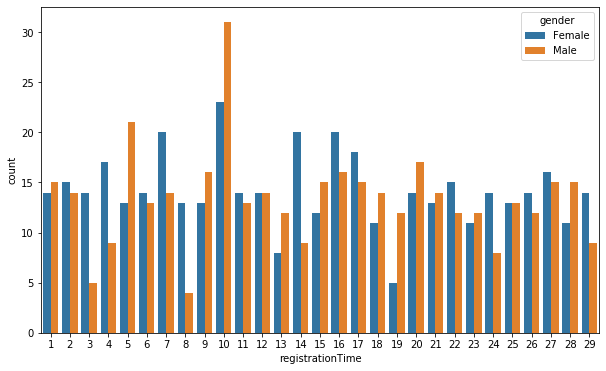

In [8]:
data['registrationTime'] = pd.to_datetime(data['registrationTime'])

a = data.loc[(data['registrationTime'] >= '2019-10-1') & (data['registrationTime'] <= '2019-10-30')]
a = a[((a['gender'] == 1) & (a['expertize'] == 0)) | ((a['gender'] == 0) & (a['expertize'] == 1))][['gender', 'registrationTime']]
a['registrationTime'] = a['registrationTime'].apply(lambda x : x.day)
a['gender'] = a['gender'].apply(lambda x : {0 : 'Female', 1 : 'Male'}[x])

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(ax=ax, x='registrationTime', hue='gender', data=a)

### K - means clustering

In [9]:
X = data[['gender', 'expertize', 'status']]

In [10]:
# standardizing data
scaler = StandardScaler()

X = scaler.fit_transform(X)

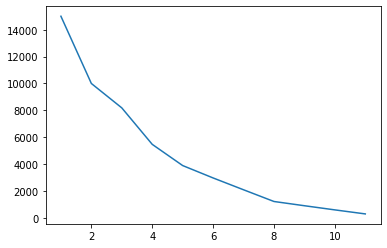

In [11]:
# find optimal cluster count using elbow method
inertias = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 12), inertias)

In [12]:
# we can see above that 8 would be optimal

kmeans = KMeans(n_clusters=8, random_state=0).fit(X)

data['cluster'] = kmeans.labels_